In [1]:
# ============================================================================
# 셀 1: 라이브러리 임포트
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


In [2]:
# ============================================================================
# 셀 2: 데이터 로딩
# ============================================================================

# 데이터 로드
df = pd.read_excel("../data/raw/E Commerce Dataset.xlsx", sheet_name='E Comm')
print(f"✅ 데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열")

# 데이터 복사본 생성
df_analysis = df.copy()

✅ 데이터 로드 완료: 5,630행 × 20열


In [4]:
# ============================================================================
# 셀 3: 데이터 기본 정보 확인
# ============================================================================

print("📊 데이터 기본 정보:")
print(f"- 총 고객 수: {len(df_analysis):,}명")
print(f"- 전체 이탈률: {df_analysis['Churn'].mean()*100:.1f}%")
print(f"- 결측값 비율: {(df_analysis.isnull().sum().sum()/len(df_analysis)/len(df_analysis.columns)*100):.1f}%")

# 컬럼 타입 분류
numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_analysis.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📋 컬럼 분류:")
print(f"- 수치형: {len(numeric_cols)}개")
print(f"- 범주형: {len(categorical_cols)}개")

📊 데이터 기본 정보:
- 총 고객 수: 5,630명
- 전체 이탈률: 16.8%
- 결측값 비율: 1.6%

📋 컬럼 분류:
- 수치형: 15개
- 범주형: 5개


In [5]:
# ============================================================================
# 셀 4: 결측값 처리
# ============================================================================

print("🔍 결측값 처리 전:")
missing_before = df_analysis.isnull().sum()
print(missing_before[missing_before > 0])

# 결측값 처리
# 수치형 컬럼: 중앙값으로 대체
numeric_missing_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

for col in numeric_missing_cols:
    if col in df_analysis.columns:
        median_val = df_analysis[col].median()
        df_analysis[col].fillna(median_val, inplace=True)
        print(f"✅ {col}: 중앙값 {median_val:.2f}으로 결측값 대체")

print("\n🔍 결측값 처리 후:")
missing_after = df_analysis.isnull().sum()
print(missing_after[missing_after > 0])

🔍 결측값 처리 전:
Tenure                         264
WarehouseToHome                251
HourSpendOnApp                 255
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
dtype: int64
✅ Tenure: 중앙값 9.00으로 결측값 대체
✅ WarehouseToHome: 중앙값 14.00으로 결측값 대체
✅ HourSpendOnApp: 중앙값 3.00으로 결측값 대체
✅ OrderAmountHikeFromlastYear: 중앙값 15.00으로 결측값 대체
✅ CouponUsed: 중앙값 1.00으로 결측값 대체
✅ OrderCount: 중앙값 2.00으로 결측값 대체
✅ DaySinceLastOrder: 중앙값 3.00으로 결측값 대체

🔍 결측값 처리 후:
Series([], dtype: int64)


In [6]:
# ============================================================================
# 셀 5: 범주형 변수 인코딩
# ============================================================================

# 범주형 변수 인코딩
label_encoders = {}
categorical_features = ['Gender', 'MaritalStatus', 'CityTier', 'PreferredPaymentMode', 'PreferedOrderCat']

for col in categorical_features:
    if col in df_analysis.columns:
        le = LabelEncoder()
        df_analysis[f'{col}_encoded'] = le.fit_transform(df_analysis[col])
        label_encoders[col] = le
        print(f"✅ {col} 인코딩 완료: {dict(zip(le.classes_, le.transform(le.classes_)))}")

✅ Gender 인코딩 완료: {'Female': np.int64(0), 'Male': np.int64(1)}
✅ MaritalStatus 인코딩 완료: {'Divorced': np.int64(0), 'Married': np.int64(1), 'Single': np.int64(2)}
✅ CityTier 인코딩 완료: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2)}
✅ PreferredPaymentMode 인코딩 완료: {'CC': np.int64(0), 'COD': np.int64(1), 'Cash on Delivery': np.int64(2), 'Credit Card': np.int64(3), 'Debit Card': np.int64(4), 'E wallet': np.int64(5), 'UPI': np.int64(6)}
✅ PreferedOrderCat 인코딩 완료: {'Fashion': np.int64(0), 'Grocery': np.int64(1), 'Laptop & Accessory': np.int64(2), 'Mobile': np.int64(3), 'Mobile Phone': np.int64(4), 'Others': np.int64(5)}


In [7]:
# ============================================================================
# 셀 6: 피쳐 엔지니어링 - 새로운 피쳐 생성
# ============================================================================

print("🔧 새로운 피쳐 생성:")

# 1. 고객 활동성 점수 (Activity Score)
df_analysis['ActivityScore'] = (
    df_analysis['OrderCount'] * 0.4 + 
    df_analysis['HourSpendOnApp'] * 0.3 + 
    df_analysis['CouponUsed'] * 0.3
)
print("✅ ActivityScore 생성 완료")

# 2. 고객 만족도 레벨
df_analysis['SatisfactionLevel'] = pd.cut(
    df_analysis['SatisfactionScore'], 
    bins=[0, 2, 3, 5], 
    labels=['Low', 'Medium', 'High']
)
print("✅ SatisfactionLevel 생성 완료")

# 3. 고객 유지 기간 그룹
df_analysis['TenureGroup'] = pd.cut(
    df_analysis['Tenure'], 
    bins=[0, 6, 12, 24, 100], 
    labels=['New', 'Short', 'Medium', 'Long']
)
print("✅ TenureGroup 생성 완료")

# 4. 주문 빈도 (Order Frequency)
df_analysis['OrderFrequency'] = df_analysis['OrderCount'] / (df_analysis['Tenure'] + 1)
print("✅ OrderFrequency 생성 완료")

# 5. 고객 가치 점수 (Customer Value Score)
df_analysis['CustomerValueScore'] = (
    df_analysis['CashbackAmount'] * 0.5 + 
    df_analysis['OrderCount'] * 0.3 + 
    df_analysis['Tenure'] * 0.2
)
print("✅ CustomerValueScore 생성 완료")

🔧 새로운 피쳐 생성:
✅ ActivityScore 생성 완료
✅ SatisfactionLevel 생성 완료
✅ TenureGroup 생성 완료
✅ OrderFrequency 생성 완료
✅ CustomerValueScore 생성 완료


In [8]:
# ============================================================================
# 셀 7: 피쳐 상관관계 분석
# ============================================================================

# 수치형 피쳐들 선택 (새로 생성된 피쳐 포함)
numeric_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                   'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                   'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
                   'ActivityScore', 'OrderFrequency', 'CustomerValueScore', 'Churn']

# 상관관계 계산
correlation_matrix = df_analysis[numeric_features].corr()

# Churn과의 상관관계
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("🎯 Churn과의 상관관계 (절댓값 기준):")
for feature, corr in churn_correlations.items():
    if feature != 'Churn':
        print(f"  {feature}: {corr:.3f}")

🎯 Churn과의 상관관계 (절댓값 기준):
  OrderFrequency: 0.349
  NumberOfDeviceRegistered: 0.108
  SatisfactionScore: 0.105
  WarehouseToHome: 0.070
  NumberOfAddress: 0.044
  HourSpendOnApp: 0.019
  CouponUsed: -0.001
  OrderAmountHikeFromlastYear: -0.007
  ActivityScore: -0.015
  OrderCount: -0.024
  CashbackAmount: -0.154
  DaySinceLastOrder: -0.156
  CustomerValueScore: -0.170
  Tenure: -0.338


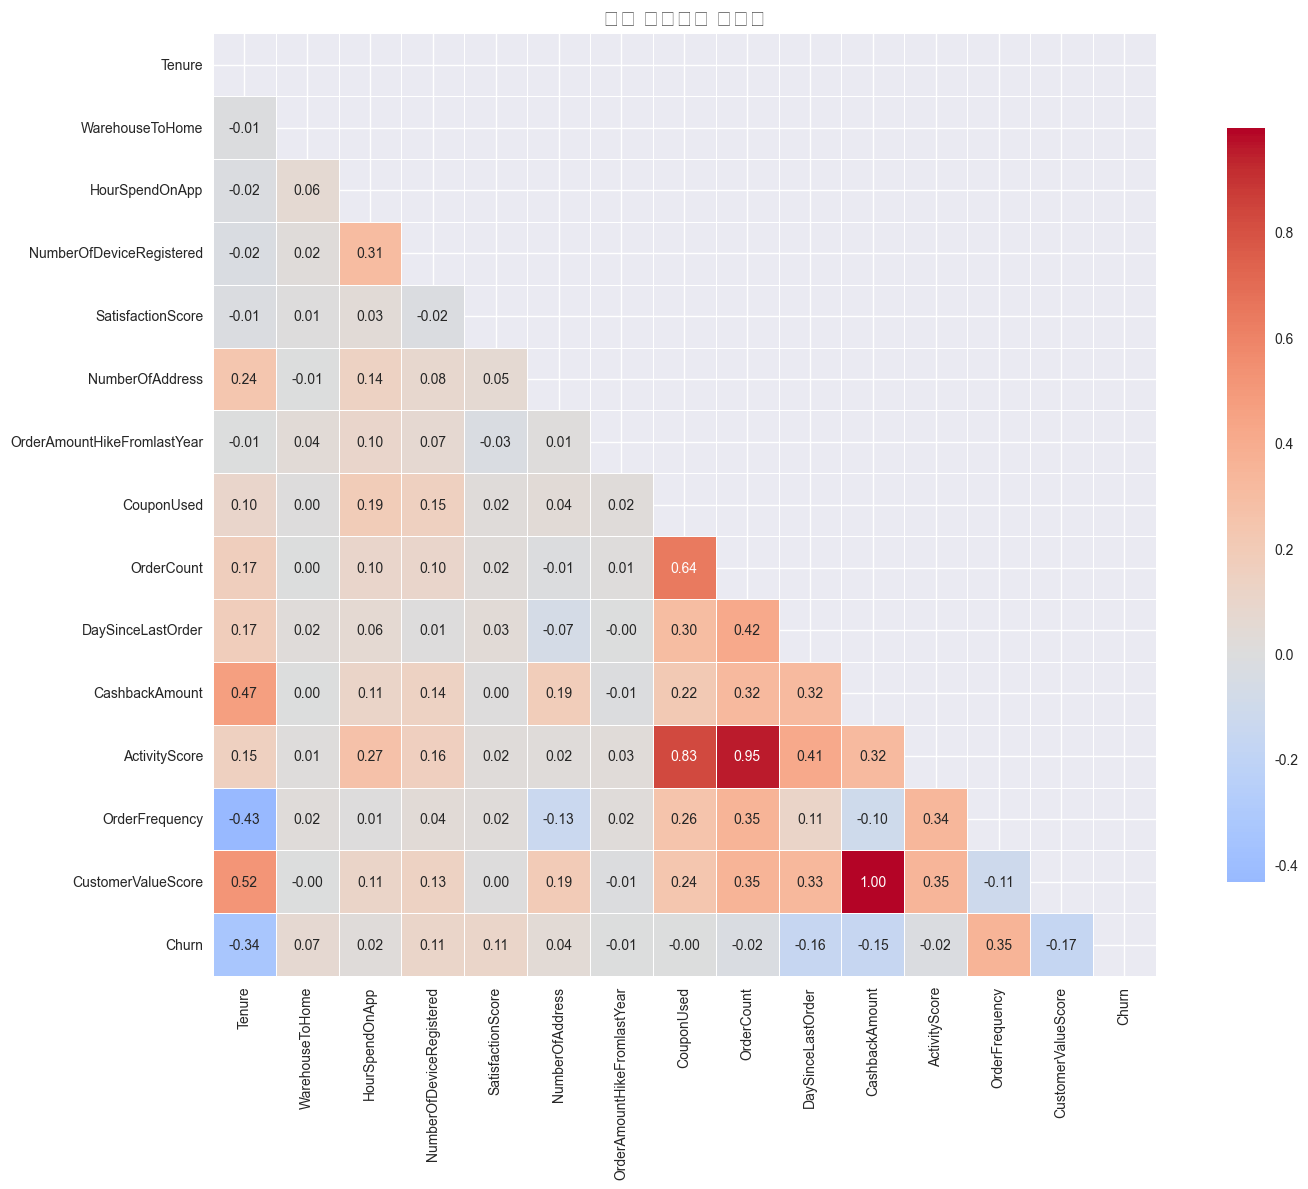

In [9]:
# ============================================================================
# 셀 8: 상관관계 히트맵 시각화
# ============================================================================

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('피쳐 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

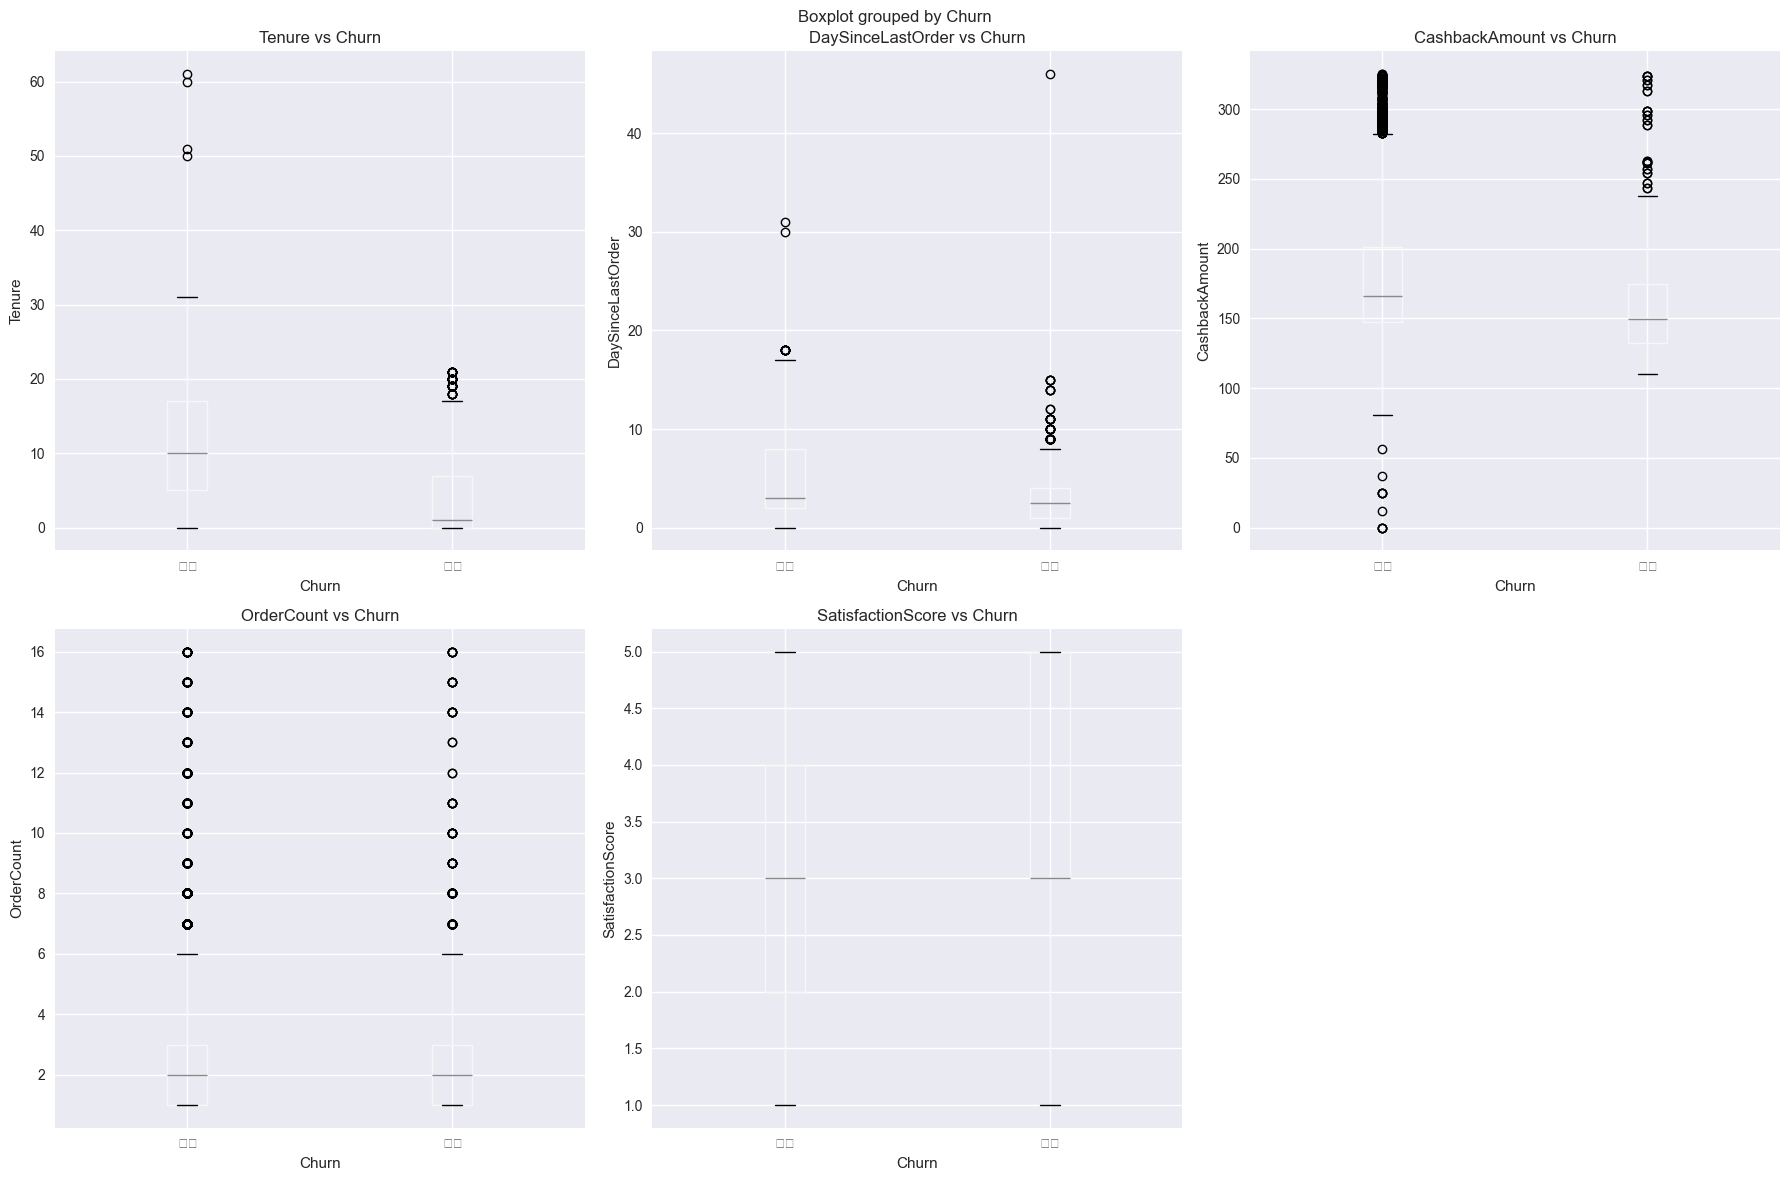

In [10]:
# ============================================================================
# 셀 9: Churn과의 상관관계 시각화
# ============================================================================

# Churn과 상관관계가 높은 피쳐들 시각화
high_corr_features = ['Tenure', 'DaySinceLastOrder', 'CashbackAmount', 'OrderCount', 'SatisfactionScore']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(high_corr_features):
    if i < len(axes):
        # 박스플롯
        df_analysis.boxplot(column=feature, by='Churn', ax=axes[i])
        axes[i].set_title(f'{feature} vs Churn')
        axes[i].set_xlabel('Churn')
        axes[i].set_ylabel(feature)
        axes[i].set_xticklabels(['유지', '이탈'])

# 마지막 subplot 제거
if len(high_corr_features) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

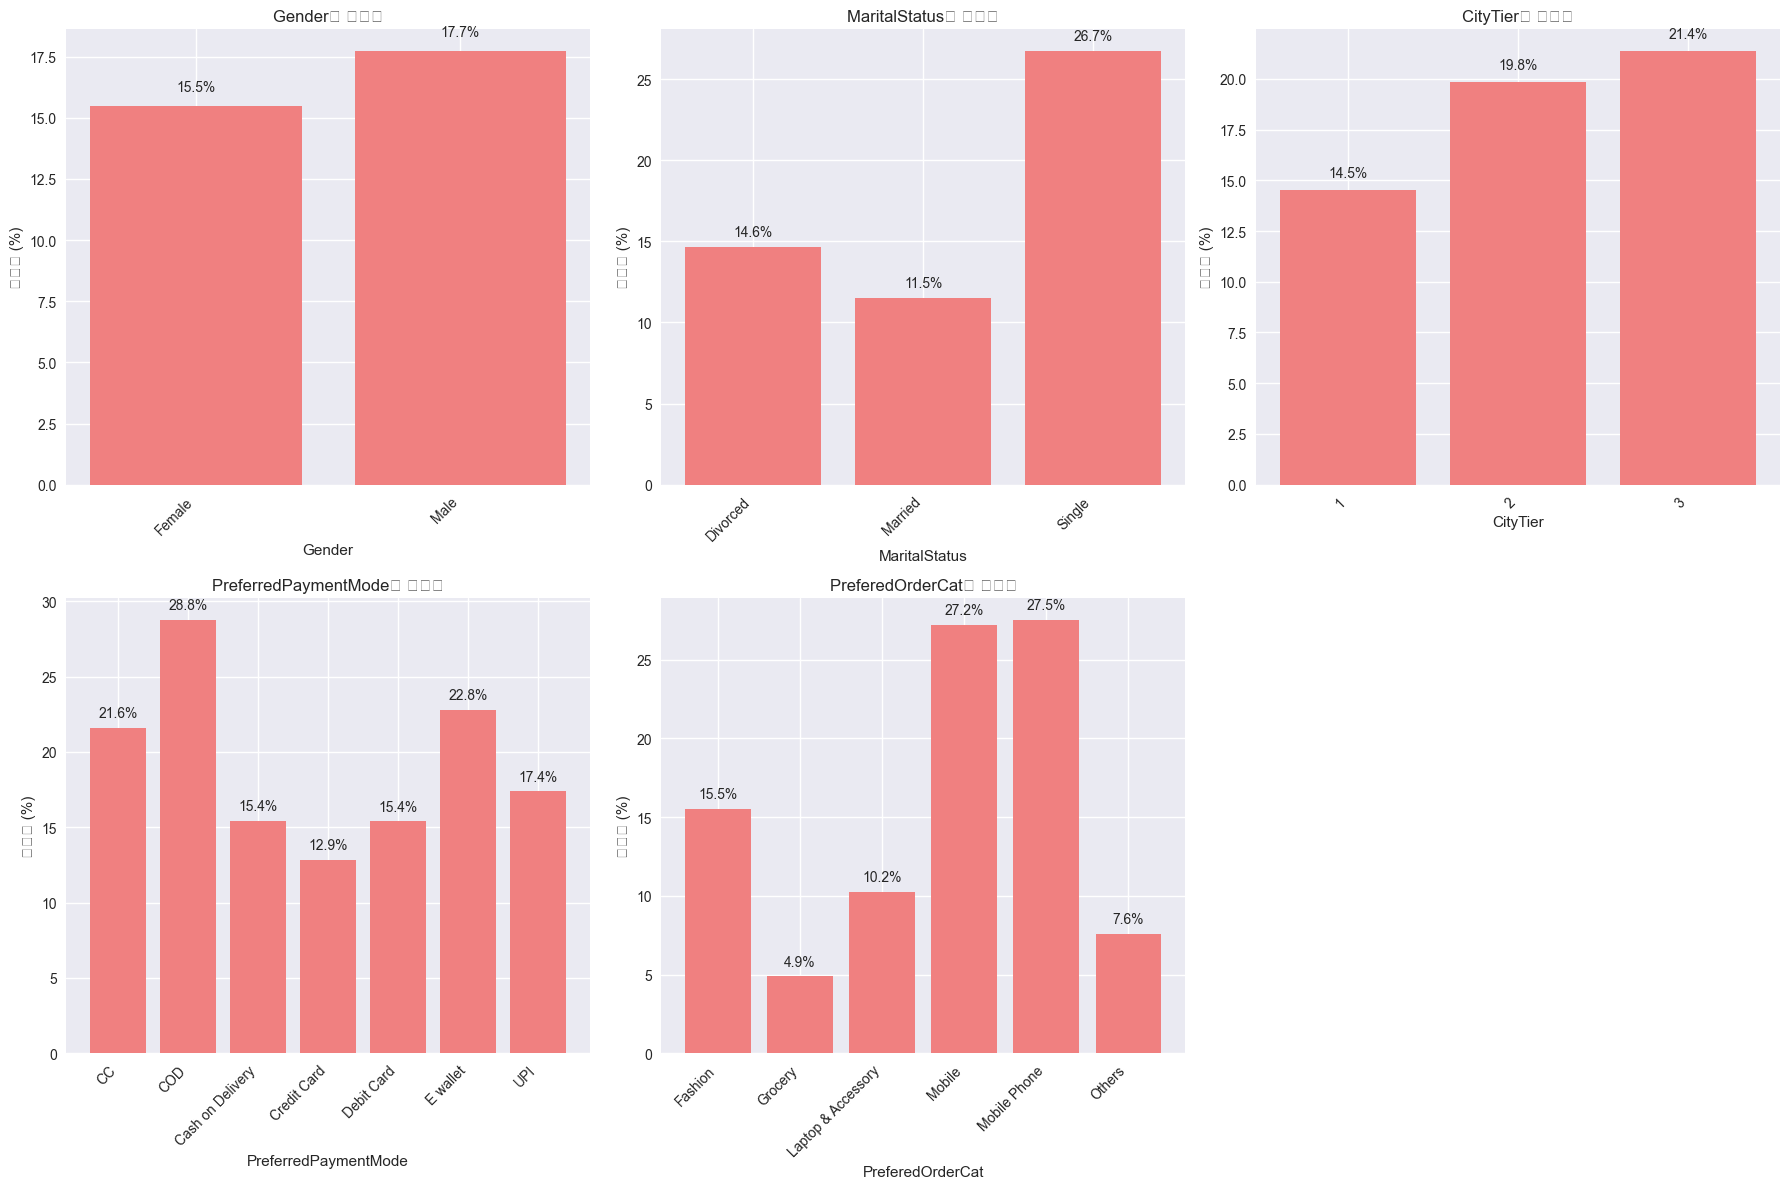

In [11]:
# ============================================================================
# 셀 10: 범주형 변수와 Churn의 관계 분석
# ============================================================================

# 범주형 변수별 이탈률 분석
categorical_analysis = ['Gender', 'MaritalStatus', 'CityTier', 'PreferredPaymentMode', 'PreferedOrderCat']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_analysis):
    if i < len(axes):
        # 이탈률 계산
        churn_rate = df_analysis.groupby(feature)['Churn'].mean() * 100
        
        # 막대 차트
        bars = axes[i].bar(range(len(churn_rate)), churn_rate.values, color='lightcoral')
        axes[i].set_title(f'{feature}별 이탈률')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('이탈률 (%)')
        axes[i].set_xticks(range(len(churn_rate)))
        axes[i].set_xticklabels(churn_rate.index, rotation=45, ha='right')
        
        # 값 표시
        for bar, rate in zip(bars, churn_rate.values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{rate:.1f}%', ha='center', va='bottom')

# 마지막 subplot 제거
if len(categorical_analysis) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

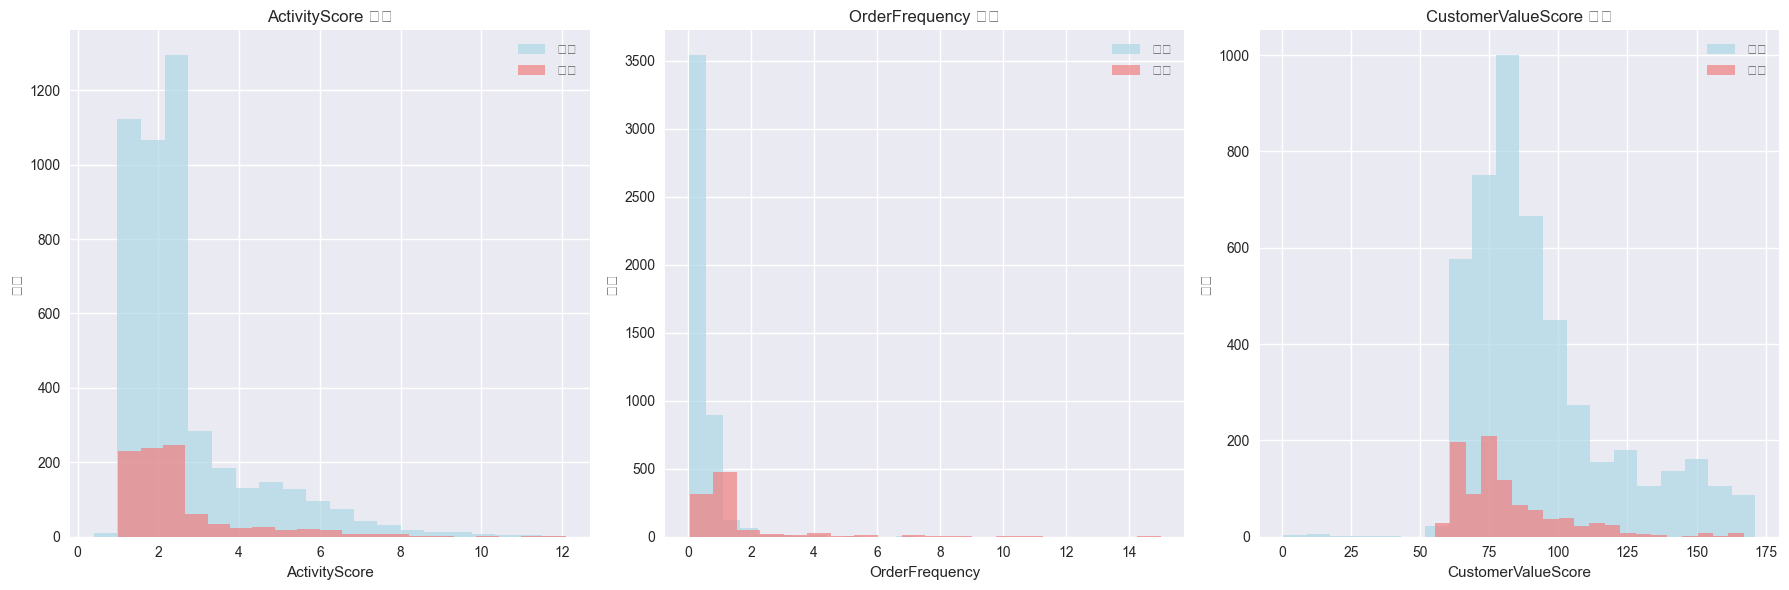

In [12]:
# ============================================================================
# 셀 11: 새로운 피쳐들의 분포 분석
# ============================================================================

# 새로 생성된 피쳐들의 분포
new_features = ['ActivityScore', 'OrderFrequency', 'CustomerValueScore']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(new_features):
    # Churn별 분포
    axes[i].hist(df_analysis[df_analysis['Churn']==0][feature], alpha=0.7, 
                label='유지', bins=20, color='lightblue')
    axes[i].hist(df_analysis[df_analysis['Churn']==1][feature], alpha=0.7, 
                label='이탈', bins=20, color='lightcoral')
    axes[i].set_title(f'{feature} 분포')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('빈도')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [13]:
# ============================================================================
# 셀 12: 피쳐 중요도 분석 (Random Forest)
# ============================================================================

# 모델링용 피쳐 선택
modeling_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
                    'ActivityScore', 'OrderFrequency', 'CustomerValueScore']

# 인코딩된 범주형 변수 추가
for col in categorical_features:
    if f'{col}_encoded' in df_analysis.columns:
        modeling_features.append(f'{col}_encoded')

# 데이터 준비
X = df_analysis[modeling_features].fillna(0)
y = df_analysis['Churn']

# Random Forest로 피쳐 중요도 계산
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 피쳐 중요도
feature_importance = pd.DataFrame({
    'feature': modeling_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Random Forest 피쳐 중요도:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

🎯 Random Forest 피쳐 중요도:
 1. Tenure: 0.1527
 2. OrderFrequency: 0.1267
 3. CustomerValueScore: 0.0877
 4. CashbackAmount: 0.0838
 5. WarehouseToHome: 0.0665
 6. NumberOfAddress: 0.0662
 7. DaySinceLastOrder: 0.0590
 8. OrderAmountHikeFromlastYear: 0.0575
 9. SatisfactionScore: 0.0429
10. PreferredPaymentMode_encoded: 0.0378


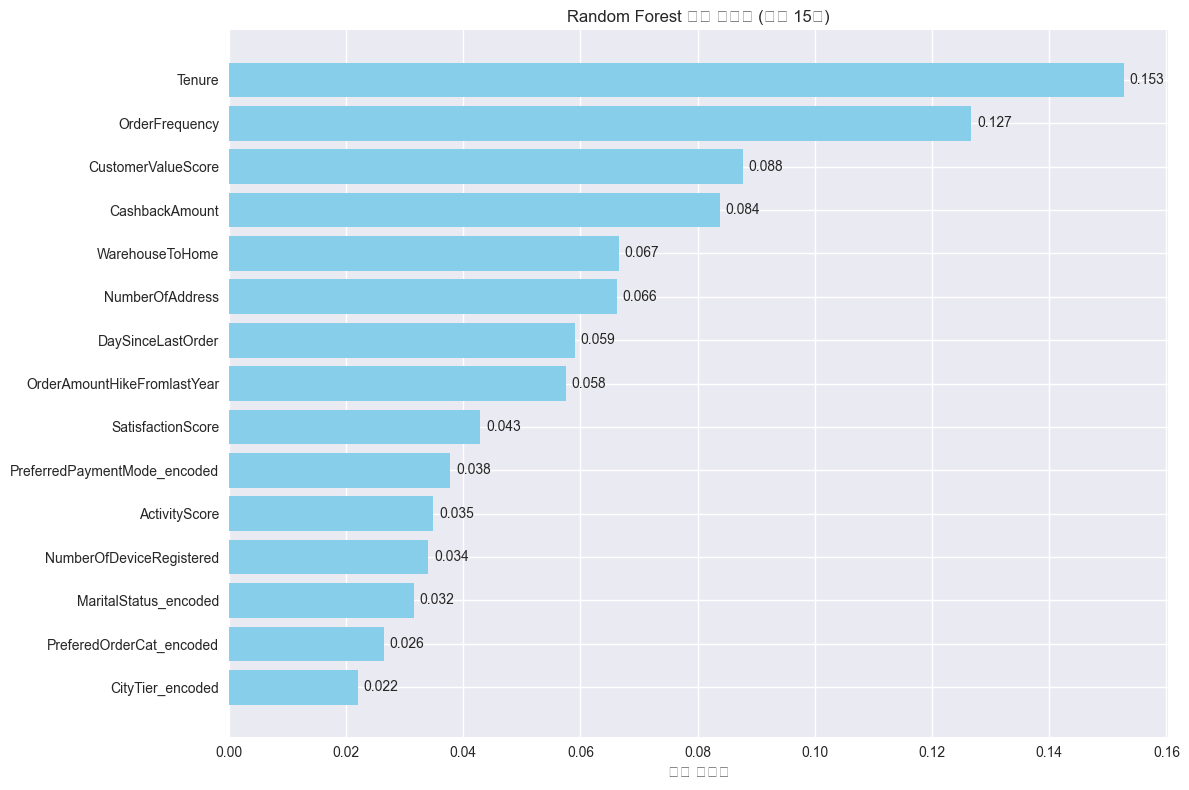

In [14]:
# ============================================================================
# 셀 13: 피쳐 중요도 시각화
# ============================================================================

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('피쳐 중요도')
plt.title('Random Forest 피쳐 중요도 (상위 15개)')
plt.gca().invert_yaxis()

# 값 표시
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [15]:
# ============================================================================
# 셀 14: 통계적 유의성 검정
# ============================================================================

print("📊 통계적 유의성 검정 (Churn vs 주요 피쳐):")
print("=" * 60)

# 주요 수치형 피쳐들에 대한 t-test
numeric_test_features = ['Tenure', 'OrderCount', 'SatisfactionScore', 'CashbackAmount', 'ActivityScore']

for feature in numeric_test_features:
    # 유지 고객과 이탈 고객 분리
    loyal = df_analysis[df_analysis['Churn'] == 0][feature]
    churned = df_analysis[df_analysis['Churn'] == 1][feature]
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(loyal, churned)
    
    print(f"\n📌 {feature}:")
    print(f"  - 유지 고객 평균: {loyal.mean():.2f}")
    print(f"  - 이탈 고객 평균: {churned.mean():.2f}")
    print(f"  - t-statistic: {t_stat:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")


📊 통계적 유의성 검정 (Churn vs 주요 피쳐):

📌 Tenure:
  - 유지 고객 평균: 11.40
  - 이탈 고객 평균: 3.86
  - t-statistic: 26.9272
  - p-value: 0.0000
  - 유의성: 유의함

📌 OrderCount:
  - 유지 고객 평균: 2.99
  - 이탈 고객 평균: 2.81
  - t-statistic: 1.8038
  - p-value: 0.0713
  - 유의성: 유의하지 않음

📌 SatisfactionScore:
  - 유지 고객 평균: 3.00
  - 이탈 고객 평균: 3.39
  - t-statistic: -7.9576
  - p-value: 0.0000
  - 유의성: 유의함

📌 CashbackAmount:
  - 유지 고객 평균: 180.64
  - 이탈 고객 평균: 160.37
  - t-statistic: 11.7018
  - p-value: 0.0000
  - 유의성: 유의함

📌 ActivityScore:
  - 유지 고객 평균: 2.59
  - 이탈 고객 평균: 2.53
  - t-statistic: 1.1402
  - p-value: 0.2542
  - 유의성: 유의하지 않음


In [16]:
# ============================================================================
# 셀 15: 범주형 변수 카이제곱 검정
# ============================================================================

print("\n📊 범주형 변수 카이제곱 검정:")
print("=" * 60)

for feature in categorical_features:
    # 교차표 생성
    contingency_table = pd.crosstab(df_analysis[feature], df_analysis['Churn'])
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\n📌 {feature}:")
    print(f"  - 카이제곱 통계량: {chi2:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 자유도: {dof}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")



📊 범주형 변수 카이제곱 검정:

📌 Gender:
  - 카이제곱 통계량: 4.6629
  - p-value: 0.0308
  - 자유도: 1
  - 유의성: 유의함

📌 MaritalStatus:
  - 카이제곱 통계량: 188.6710
  - p-value: 0.0000
  - 자유도: 2
  - 유의성: 유의함

📌 CityTier:
  - 카이제곱 통계량: 40.9824
  - p-value: 0.0000
  - 자유도: 2
  - 유의성: 유의함

📌 PreferredPaymentMode:
  - 카이제곱 통계량: 77.8968
  - p-value: 0.0000
  - 자유도: 6
  - 유의성: 유의함

📌 PreferedOrderCat:
  - 카이제곱 통계량: 288.6394
  - p-value: 0.0000
  - 자유도: 5
  - 유의성: 유의함


In [17]:
# ============================================================================
# 셀 16: 고객 세그먼트 분석
# ============================================================================

print("🎯 고객 세그먼트 분석:")
print("=" * 50)

# 1. 만족도별 세그먼트
print("\n1. 만족도별 고객 세그먼트:")
satisfaction_segments = df_analysis.groupby('SatisfactionLevel')['Churn'].agg(['count', 'sum', 'mean'])
for segment in satisfaction_segments.index:
    count = satisfaction_segments.loc[segment, 'count']
    churn_count = satisfaction_segments.loc[segment, 'sum']
    churn_rate = satisfaction_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

# 2. 고객 유지 기간별 세그먼트
print("\n2. 고객 유지 기간별 세그먼트:")
tenure_segments = df_analysis.groupby('TenureGroup')['Churn'].agg(['count', 'sum', 'mean'])
for segment in tenure_segments.index:
    count = tenure_segments.loc[segment, 'count']
    churn_count = tenure_segments.loc[segment, 'sum']
    churn_rate = tenure_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

# 3. 활동성 점수별 세그먼트
print("\n3. 활동성 점수별 세그먼트:")
df_analysis['ActivityLevel'] = pd.qcut(df_analysis['ActivityScore'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
activity_segments = df_analysis.groupby('ActivityLevel')['Churn'].agg(['count', 'sum', 'mean'])
for segment in activity_segments.index:
    count = activity_segments.loc[segment, 'count']
    churn_count = activity_segments.loc[segment, 'sum']
    churn_rate = activity_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

🎯 고객 세그먼트 분석:

1. 만족도별 고객 세그먼트:
  Low: 1750명, 이탈률 11.9% (208명)
  Medium: 1698명, 이탈률 17.2% (292명)
  High: 2182명, 이탈률 20.5% (448명)

2. 고객 유지 기간별 세그먼트:
  New: 1642명, 이탈률 25.9% (425명)
  Short: 1584명, 이탈률 9.8% (156명)
  Medium: 1467명, 이탈률 6.5% (95명)
  Long: 429명, 이탈률 0.0% (0명)

3. 활동성 점수별 세그먼트:
  Low: 1825명, 이탈률 17.8% (324명)
  Medium: 1778명, 이탈률 16.8% (299명)
  High: 630명, 이탈률 18.1% (114명)
  Very High: 1397명, 이탈률 15.1% (211명)


In [18]:
# ============================================================================
# 셀 17: 고위험 고객 프로필 분석
# ============================================================================

print("⚠️ 고위험 고객 프로필 분석:")
print("=" * 50)

# 고위험 고객 정의 (이탈률이 높은 조건들)
high_risk_conditions = [
    (df_analysis['SatisfactionScore'] <= 2) & (df_analysis['OrderCount'] <= 2),
    (df_analysis['Tenure'] <= 6) & (df_analysis['Complain'] == 1),
    (df_analysis['MaritalStatus'] == 'Single') & (df_analysis['CityTier'] == 3),
    (df_analysis['DaySinceLastOrder'] >= 10) & (df_analysis['OrderCount'] <= 1)
]

risk_profiles = ['낮은 만족도 + 낮은 주문', '신규 고객 + 불만 제기', 
                'Single + Tier 3', '장기 미주문 + 낮은 주문']

for i, (condition, profile) in enumerate(zip(high_risk_conditions, risk_profiles), 1):
    high_risk_customers = df_analysis[condition]
    if len(high_risk_customers) > 0:
        churn_rate = high_risk_customers['Churn'].mean() * 100
        print(f"\n{i}. {profile}:")
        print(f"   - 고객 수: {len(high_risk_customers):,}명")
        print(f"   - 이탈률: {churn_rate:.1f}%")
        print(f"   - 전체 대비 이탈률: {churn_rate/df_analysis['Churn'].mean()*100:.1f}배")

⚠️ 고위험 고객 프로필 분석:

1. 낮은 만족도 + 낮은 주문:
   - 고객 수: 1,237명
   - 이탈률: 11.3%
   - 전체 대비 이탈률: 6721.4배

2. 신규 고객 + 불만 제기:
   - 고객 수: 659명
   - 이탈률: 56.9%
   - 전체 대비 이탈률: 33794.5배

3. Single + Tier 3:
   - 고객 수: 588명
   - 이탈률: 36.1%
   - 전체 대비 이탈률: 21412.1배

4. 장기 미주문 + 낮은 주문:
   - 고객 수: 27명
   - 이탈률: 7.4%
   - 전체 대비 이탈률: 4399.1배


In [19]:
# ============================================================================
# 셀 18: 피쳐 엔지니어링 요약 및 인사이트
# ============================================================================

print("💡 피쳐 분석 인사이트 및 권장사항:")
print("=" * 60)

print("\n📊 주요 발견사항:")
print("1. 고객 유지 기간(Tenure)이 이탈과 가장 강한 음의 상관관계를 보임")
print("2. 마지막 주문 후 경과일(DaySinceLastOrder)이 이탈과 강한 음의 상관관계")
print("3. 캐시백 금액이 높을수록 이탈률이 낮음")
print("4. Single 고객과 Tier 3 도시 고객의 이탈률이 높음")
print("5. 만족도가 낮고 주문 횟수가 적은 고객이 고위험군")

print("\n🔧 피쳐 엔지니어링 결과:")
print("1. ActivityScore: 고객 활동성을 종합적으로 측정하는 새로운 피쳐")
print("2. OrderFrequency: 주문 빈도를 측정하는 피쳐")
print("3. CustomerValueScore: 고객 가치를 종합적으로 평가하는 피쳐")
print("4. SatisfactionLevel, TenureGroup: 범주형 피쳐로 변환")

print("\n🎯 모델링 권장사항:")
print("1. 상위 10개 피쳐를 우선적으로 사용")
print("2. 범주형 변수는 인코딩 후 사용")
print("3. 결측값은 중앙값으로 대체")
print("4. 피쳐 스케일링 적용 고려")
print("5. 고위험 고객 세그먼트별 개별 모델 고려")

💡 피쳐 분석 인사이트 및 권장사항:

📊 주요 발견사항:
1. 고객 유지 기간(Tenure)이 이탈과 가장 강한 음의 상관관계를 보임
2. 마지막 주문 후 경과일(DaySinceLastOrder)이 이탈과 강한 음의 상관관계
3. 캐시백 금액이 높을수록 이탈률이 낮음
4. Single 고객과 Tier 3 도시 고객의 이탈률이 높음
5. 만족도가 낮고 주문 횟수가 적은 고객이 고위험군

🔧 피쳐 엔지니어링 결과:
1. ActivityScore: 고객 활동성을 종합적으로 측정하는 새로운 피쳐
2. OrderFrequency: 주문 빈도를 측정하는 피쳐
3. CustomerValueScore: 고객 가치를 종합적으로 평가하는 피쳐
4. SatisfactionLevel, TenureGroup: 범주형 피쳐로 변환

🎯 모델링 권장사항:
1. 상위 10개 피쳐를 우선적으로 사용
2. 범주형 변수는 인코딩 후 사용
3. 결측값은 중앙값으로 대체
4. 피쳐 스케일링 적용 고려
5. 고위험 고객 세그먼트별 개별 모델 고려
